In [1]:
# import the necessary packages
from musicsearchmodel.dataset import TripletGenerator
from musicsearchmodel.dataset import MapFunction
from musicsearchmodel.model import SiameseModel
from matplotlib import pyplot as plt
from musicsearchmodel import config
from tensorflow import keras
import tensorflow as tf
import os
# create the data input pipeline for test dataset
print("[INFO] building the test generator...")
testTripletGenerator = TripletGenerator(
    datasetPath=config.TEST_DATASET)
print("[INFO] building the test `tf.data` dataset...")
testTfDataset = tf.data.Dataset.from_generator(generator=testTripletGenerator.get_next_element,
    output_types=(tf.string, tf.string, tf.string),
    output_shapes=(tf.TensorShape([]), tf.TensorShape([]), tf.TensorShape([]))
)
mapFunction = MapFunction(imageSize=config.IMAGE_SIZE)
testDs = (testTfDataset
          .map(mapFunction)
          .batch(4)
          .prefetch(config.AUTO)
)

[INFO] building the test generator...
[INFO] building the test `tf.data` dataset...


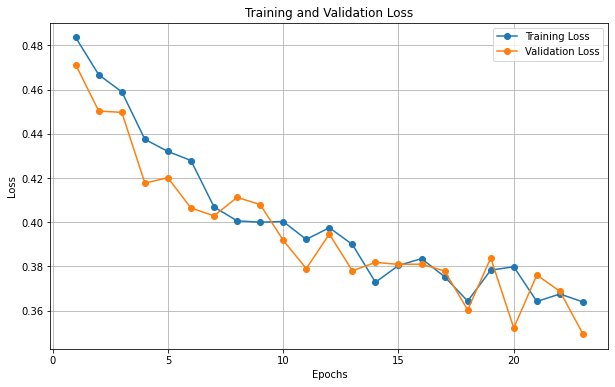

In [3]:
import matplotlib.pyplot as plt

# Loss values for each epoch
epochs = list(range(1, 24))
train_loss = [0.4836, 0.4667, 0.4590, 0.4375, 0.4320, 0.4279, 0.4069, 0.4006, 0.4000, 0.4003,
              0.3922, 0.3975, 0.3899, 0.3728, 0.3804, 0.3835, 0.3753, 0.3643, 0.3783, 0.3798,
              0.3641, 0.3675, 0.3639]
val_loss = [0.4713, 0.4503, 0.4497, 0.4177, 0.4201, 0.4064, 0.4029, 0.4112, 0.4080, 0.3918,
            0.3790, 0.3946, 0.3780, 0.3818, 0.3809, 0.3810, 0.3779, 0.3603, 0.3838, 0.3521,
            0.3761, 0.3687, 0.3494]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

[INFO] loading the siamese network from output\siamese_network...
[INFO] saving the inference image to output\output_image.png...


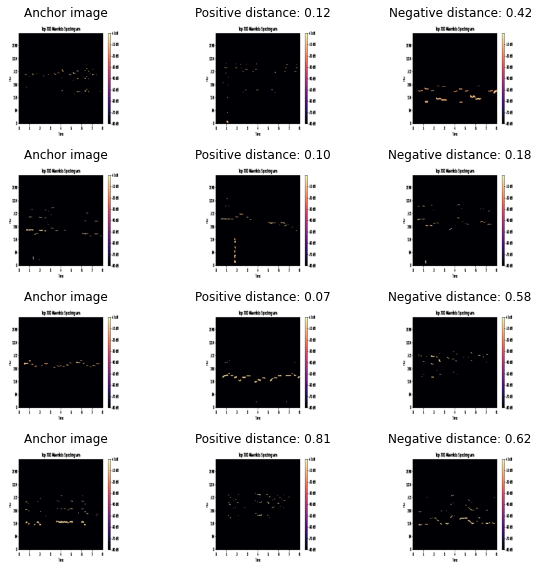

In [2]:
# load the siamese network from disk and build the siamese model
modelPath = config.MODEL_PATH
print(f"[INFO] loading the siamese network from {modelPath}...")
siameseNetwork = keras.models.load_model(filepath=modelPath)
siameseModel = SiameseModel(
    siameseNetwork=siameseNetwork,
    margin=0.5,
    lossTracker=keras.metrics.Mean(name="loss"),
)
# load the test data
(anchor, positive, negative) = next(iter(testDs))
(apDistance, anDistance) = siameseModel((anchor, positive, negative))
plt.figure(figsize=(10, 10))
rows = 4
for row in range(rows):
    plt.subplot(rows, 3, row * 3 + 1)
    plt.imshow(anchor[row])
    plt.axis("off")
    plt.title("Anchor image")
    plt.subplot(rows, 3, row * 3 + 2)
    plt.imshow(positive[row])
    plt.axis("off")
    plt.title(f"Positive distance: {apDistance[row]:0.2f}")
    plt.subplot(rows, 3, row * 3 + 3)
    plt.imshow(negative[row])
    plt.axis("off")
    plt.title(f"Negative distance: {anDistance[row]:0.2f}")
# check if the output directory exists, if it doesn't, then
# create it
if not os.path.exists(config.OUTPUT_PATH):
    os.makedirs(config.OUTPUT_PATH)
# save the inference image to disk
outputImagePath = config.OUTPUT_IMAGE_PATH
print(f"[INFO] saving the inference image to {outputImagePath}...")
plt.savefig(fname=outputImagePath)